# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- Use Pandas to load, inspect, and clean the dataset appropriately. 
- Transform relevant columns to create measures that address the problem at hand.
- **conduct EDA: visualization and statistical measures to understand the structure of the data**
- **recommend a set of manufacturers to consider as well as specific airplanes conforming to the client's request**
- **discuss the relationship between serious injuries/airplane damage incurred and at least *two* factors at play in the incident. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.**

In [1]:
# loading relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis  
- Load in the cleaned data

In [2]:
# Load cleaned data produced by the cleaning notebook
df = pd.read_csv("data/aviation_cleaned.csv")

# Quick sanity checks
print("Shape:", df.shape)
display(df.head(3))
df[['fatal_serious_frac','is_destroyed','passenger_total_est']].describe()

Shape: (16539, 31)


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Injury.Severity,Aircraft.damage,...,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Event.Year,passenger_total_est,fatal_serious_total,fatal_serious_frac,is_destroyed,Make_Model
0,20001214X42331,Accident,ATL83FA140,1983-03-20,"CROSSVILLE, TN",United States,NaN,NaN,Fatal(1),Destroyed,...,0.0,0.0,IMC,Cruise,1983,2.0,2.0,1.0,1,Piper Pa-28-140
1,20001214X42672,Accident,FTW83LA177,1983-04-02,"MCKINNEY, TX",United States,NaN,NaN,Fatal(1),NaN,...,0.0,4.0,VMC,Standing,1983,5.0,1.0,0.2,0,De Havilland Dhc-6
2,20001214X45188,Accident,NYC84LA028,1983-11-13,"MARTHA'S VINEYARD, MA",United States,NaN,NaN,Non-Fatal,Substantial,...,0.0,1.0,VMC,Climb,1983,1.0,0.0,0.0,0,Beech C35


,fatal_serious_frac,is_destroyed,passenger_total_est
count,16337.000000,16539.000000,16539.000000
mean,0.287262,0.110224,6.313018
std,0.431999,0.313179,29.590774
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,2.000000
75%,0.833333,0.000000,2.000000
max,1.000000,1.000000,576.000000


## Explore safety metrics across models/makes
- Remember that the client is interested in separate recommendations for smaller airplanes and larger airplanes. Choose a passenger threshold of 20 and separate the plane types. 

In [3]:
# Passenger threshold requested by the client
PASSENGER_THRESHOLD = 20

# Use estimated passengers onboard in the accident record as a proxy for "small vs large"
df = df.copy()
df["plane_size"] = np.where(df["passenger_total_est"] < PASSENGER_THRESHOLD,
                            "Small",
                            "Large")

# Keep rows where our safety metric exists
df = df[df["fatal_serious_frac"].notna()].copy()

df["plane_size"].value_counts()

plane_size
Small    15871
Large      466
Name: count, dtype: int64

#### Analyzing Makes

Explore the human injury risk profile for small and larger Makes:
- choose the 15 makes for each group possessing the lowest mean fatal/seriously injured fraction
- plot the mean fatal/seriously injured fraction for each of these subgroups side-by-side

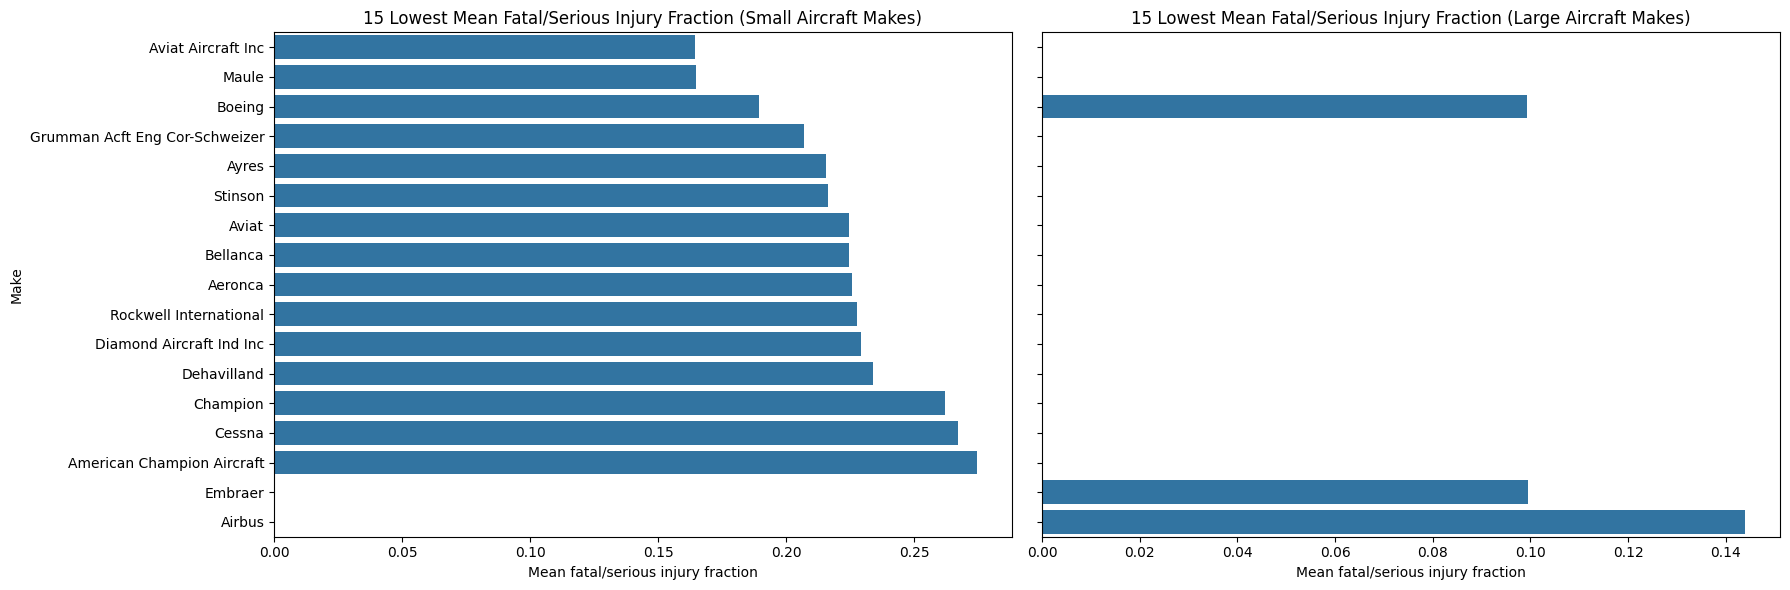

In [4]:
# Aggregate safety metrics by Make and plane_size
make_summary = (
    df.groupby(["plane_size", "Make"])
      .agg(
          n_accidents=("Make", "size"),
          mean_fatal_serious_frac=("fatal_serious_frac", "mean"),
          destroyed_rate=("is_destroyed", "mean")
      )
      .reset_index()
)


# Keep only statistically-robust groups
MIN_SAMPLES_MAKE = 50
make_summary_robust = make_summary[make_summary["n_accidents"] >= MIN_SAMPLES_MAKE].copy()

# 15 safest makes (by mean fatal/serious fraction) for each size group
top15_small = (make_summary_robust[make_summary_robust["plane_size"] == "Small"]
               .nsmallest(15, "mean_fatal_serious_frac"))
top15_large = (make_summary_robust[make_summary_robust["plane_size"] == "Large"]
               .nsmallest(15, "mean_fatal_serious_frac"))

# Side-by-side bar plot
fig, ax = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)

sns.barplot(data=top15_small, x="mean_fatal_serious_frac", y="Make", ax=ax[0])
ax[0].set_title("15 Lowest Mean Fatal/Serious Injury Fraction (Small Aircraft Makes)")
ax[0].set_xlabel("Mean fatal/serious injury fraction")
ax[0].set_ylabel("Make")

sns.barplot(data=top15_large, x="mean_fatal_serious_frac", y="Make", ax=ax[1])
ax[1].set_title("15 Lowest Mean Fatal/Serious Injury Fraction (Large Aircraft Makes)")
ax[1].set_xlabel("Mean fatal/serious injury fraction")


plt.tight_layout()


**Distribution of injury rates: small makes**

Use a violinplot to look at the distribution of the fraction of passengers serious/fatally injured for small airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

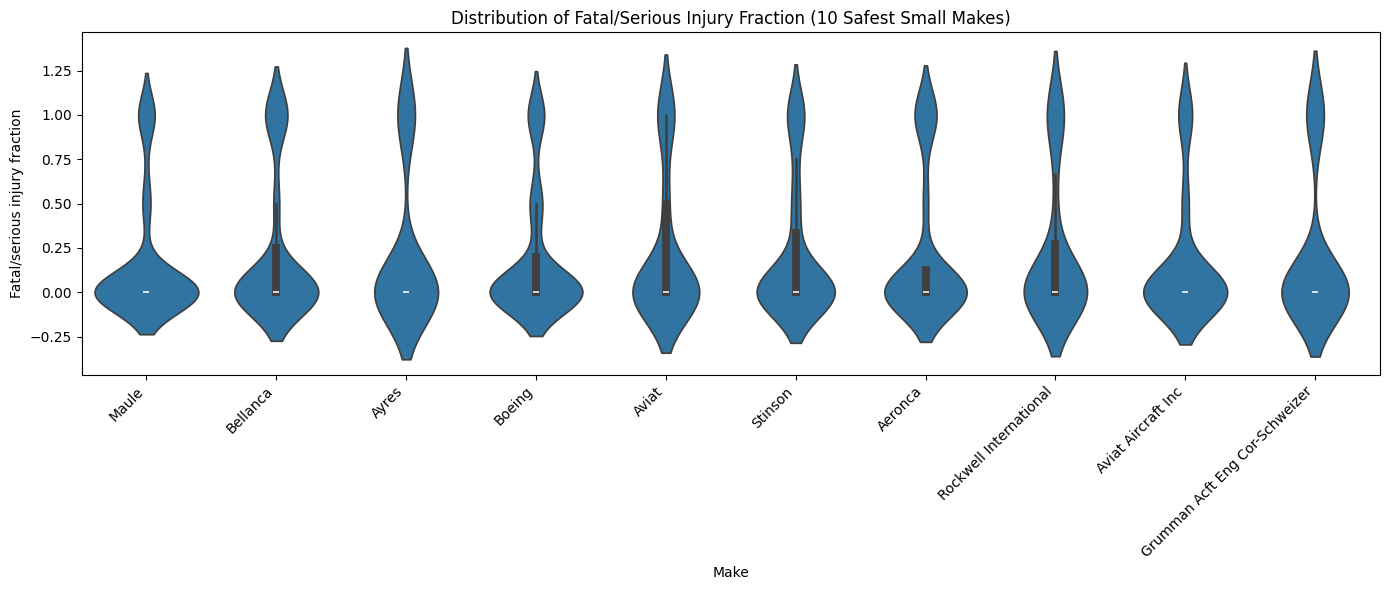

In [12]:
# 10 safest small makes by mean fatal/serious fraction 
top10_small = (make_summary_robust[make_summary_robust["plane_size"].str.startswith("Small")]
               .nsmallest(10, "mean_fatal_serious_frac"))

small_makes_10 = df[df["Make"].isin(top10_small["Make"]) & (df["plane_size"] == "Small")].copy()

plt.figure(figsize=(14, 6))
sns.violinplot(data=small_makes_10, x="Make", y="fatal_serious_frac")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Fatal/Serious Injury Fraction (10 Safest Small Makes)")
plt.xlabel("Make")
plt.ylabel("Fatal/serious injury fraction")
plt.tight_layout()

**Distribution of injury rates: large makes**

Use a stripplot to look at the distribution of the fraction of passengers serious/fatally injured for large airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

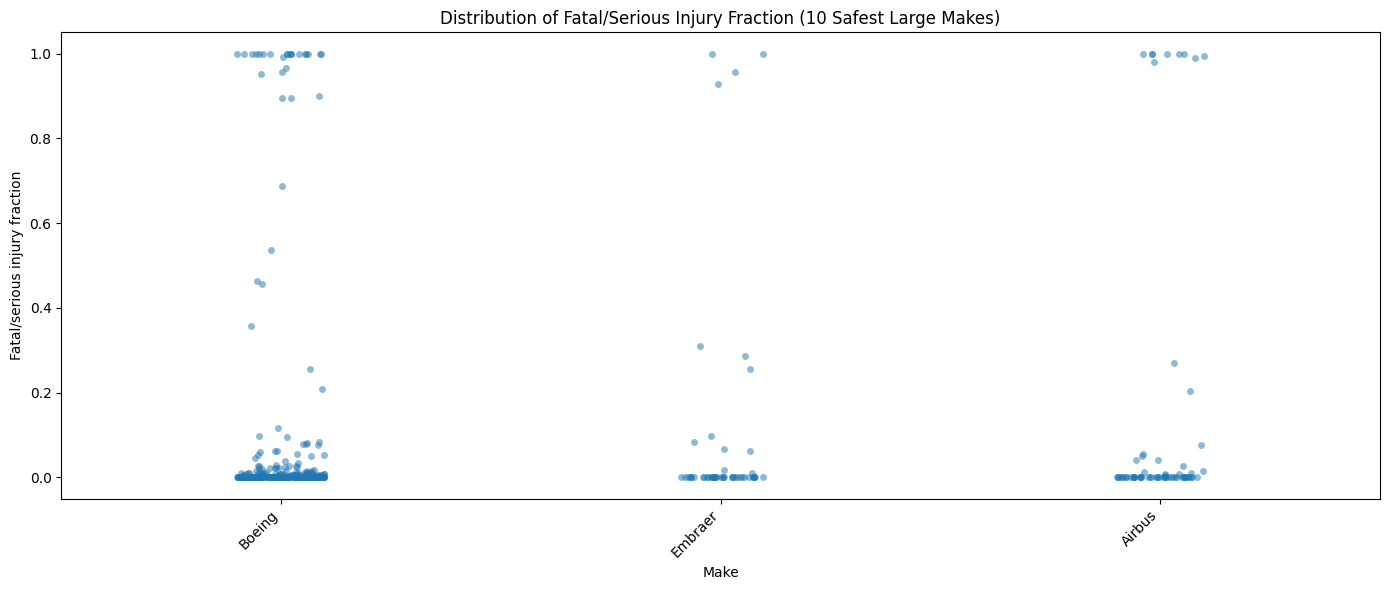

In [6]:
top10_large = (make_summary_robust[make_summary_robust["plane_size"] == "Large"]
               .nsmallest(10, "mean_fatal_serious_frac"))

large_makes_10 = df[df["Make"].isin(top10_large["Make"]) & (df["plane_size"] == "Large")].copy()

plt.figure(figsize=(14, 6))
sns.stripplot(data=large_makes_10, x="Make", y="fatal_serious_frac", alpha=0.5)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Fatal/Serious Injury Fraction (10 Safest Large Makes)")
plt.xlabel("Make")
plt.ylabel("Fatal/serious injury fraction")
plt.tight_layout()


**Evaluate the rate of aircraft destruction for both small and large aircraft by Make.** 

Sort your results and keep the lowest 15.

,Make,n_accidents,mean_fatal_serious_frac,destroyed_rate
0,Aviat Aircraft Inc,76,0.164474,0.039474
1,Maule,215,0.164806,0.041860
2,Boeing,188,0.189450,0.117021
3,Grumman Acft Eng Cor-Schweizer,58,0.206897,0.017241
4,Ayres,51,0.215686,0.117647
5,Stinson,129,0.216408,0.023256
6,Aviat,69,0.224638,0.101449
7,Bellanca,217,0.224654,0.050691
8,Aeronca,200,0.225833,0.035000
9,Rockwell International,56,0.227679,0.125000


,Make,n_accidents,mean_fatal_serious_frac,destroyed_rate
0,Boeing,297,0.099316,0.090909
1,Embraer,51,0.099474,0.078431
2,Airbus,68,0.143900,0.132353


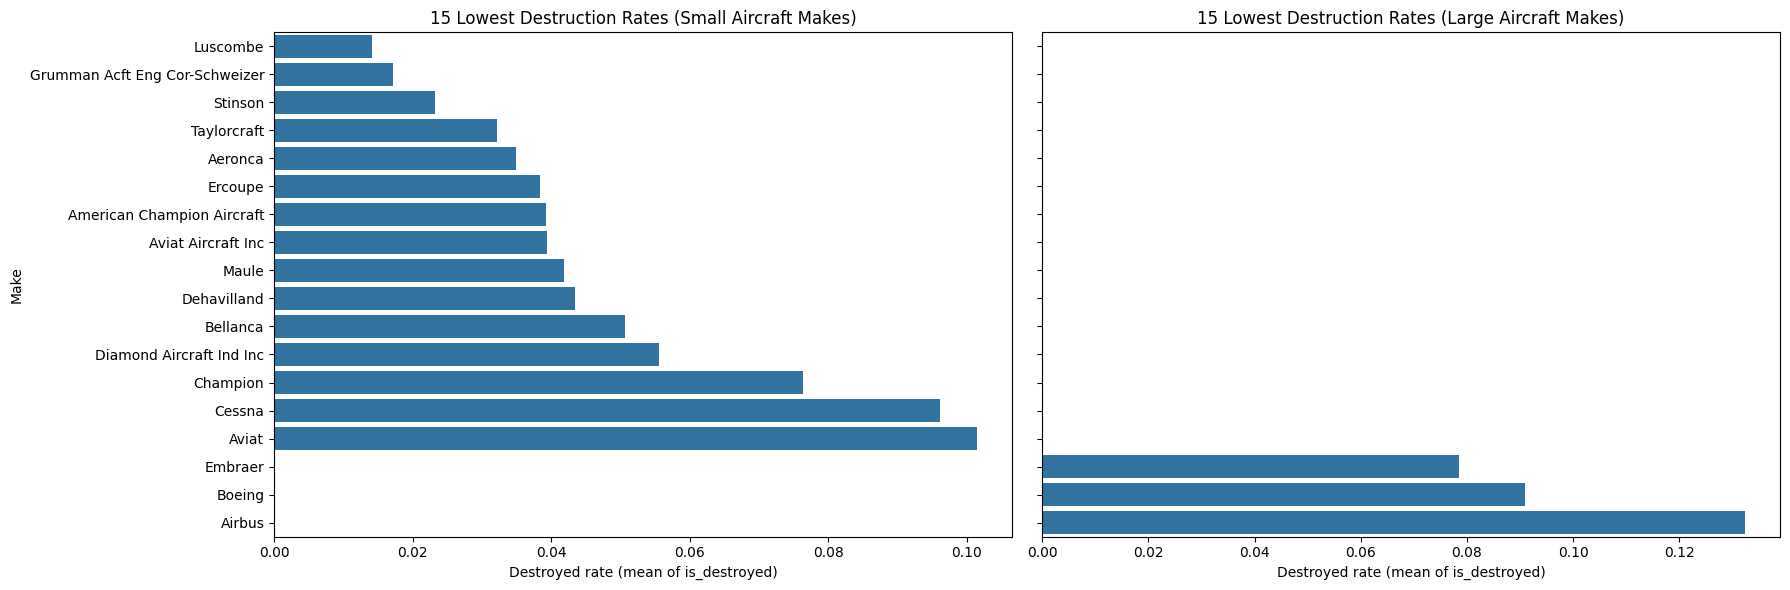

In [ ]:
# 15 lowest destroyed rates for each size group
top15_small_destroy = (make_summary_robust[make_summary_robust["plane_size"] == "Small"]
                       .nsmallest(15, "destroyed_rate"))
top15_large_destroy = (make_summary_robust[make_summary_robust["plane_size"] == "Large"]
                       .nsmallest(15, "destroyed_rate"))

fig, ax = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)

sns.barplot(data=top15_small_destroy, x="destroyed_rate", y="Make", ax=ax[0])
ax[0].set_title("15 Lowest Destruction Rates (Small Aircraft Makes)")
ax[0].set_xlabel("Destroyed rate (mean of is_destroyed)")
ax[0].set_ylabel("Make")

sns.barplot(data=top15_large_destroy, x="destroyed_rate", y="Make", ax=ax[1])
ax[1].set_title("15 Lowest Destruction Rates (Large Aircraft Makes)")
ax[1].set_xlabel("Destroyed rate (mean of is_destroyed)")
ax[1].set_ylabel("")

plt.tight_layout()

# Tables for recommendations 
display(top15_small[["Make","n_accidents","mean_fatal_serious_frac","destroyed_rate"]].reset_index(drop=True))
display(top15_large[["Make","n_accidents","mean_fatal_serious_frac","destroyed_rate"]].reset_index(drop=True))


#### Provide a short discussion on your findings for your summary statistics and plots:
- Make any recommendations for Makes here based off of the destroyed fraction and fraction fatally/seriously injured
- Comment on the calculated statistics and any corresponding distributions you have visualized.

## Make-Level Safety Evaluation and Final Recommendation

Aircraft safety was evaluated using:

- Mean Fatal/Serious Injury Fraction  
- Aircraft Destruction Rate  

Only makes with at least 50 accidents were included to ensure statistical robustness.

---

### Recommended Small Aircraft Makes

Based on consistently low fatal/serious injury fractions and low destruction rates, the strongest-performing small-aircraft manufacturers are:

- **Aviat Aircraft Inc**
- **Maule**
- **Grumman Acft Eng Cor-Schweizer**
- **Stinson**
- **Aeronca**

These manufacturers demonstrate lower injury severity (approximately 16–23%) and relatively low destruction rates compared to other small-aircraft makes in the dataset.

---

### Recommended Large Passenger Aircraft Makes

Among larger aircraft (≥20 passengers), the top-performing manufacturers are:

- **Embraer**
- **Boeing**

Both exhibit very low fatal/serious injury fractions (~10%) and relatively low destruction rates.  
Airbus also performs strongly but shows slightly higher destruction and injury fractions compared to Embraer and Boeing.

---

### Interpretation Note

This analysis reflects severity conditional on accidents occurring, not overall accident frequency. Results therefore represent relative damage and injury outcomes given an accident — which aligns with insurer risk exposure.

### Analyze plane types
- plot the mean fatal/seriously injured fraction for both small and larger planes 
- also provide a distributional plot of your choice for the fatal/seriously injured fraction by airplane type (stripplot, violin, etc)  
- filter ensuring that you have at least ten individual examples in each model/make to average over

**Larger planes**

,Make_Model,n_accidents,mean_fatal_serious_frac,destroyed_rate,make
0,Boeing 777,12,0.002258,0.083333,Boeing
1,Boeing 757,10,0.002651,0.000000,Boeing
2,Embraer Emb-145Lr,10,0.015000,0.000000,Embraer
3,Boeing 737 7H4,12,0.079474,0.000000,Boeing
4,Boeing 767,18,0.080531,0.055556,Boeing
5,Boeing 737,76,0.173053,0.144737,Boeing
6,Airbus A320,11,0.273252,0.272727,Airbus


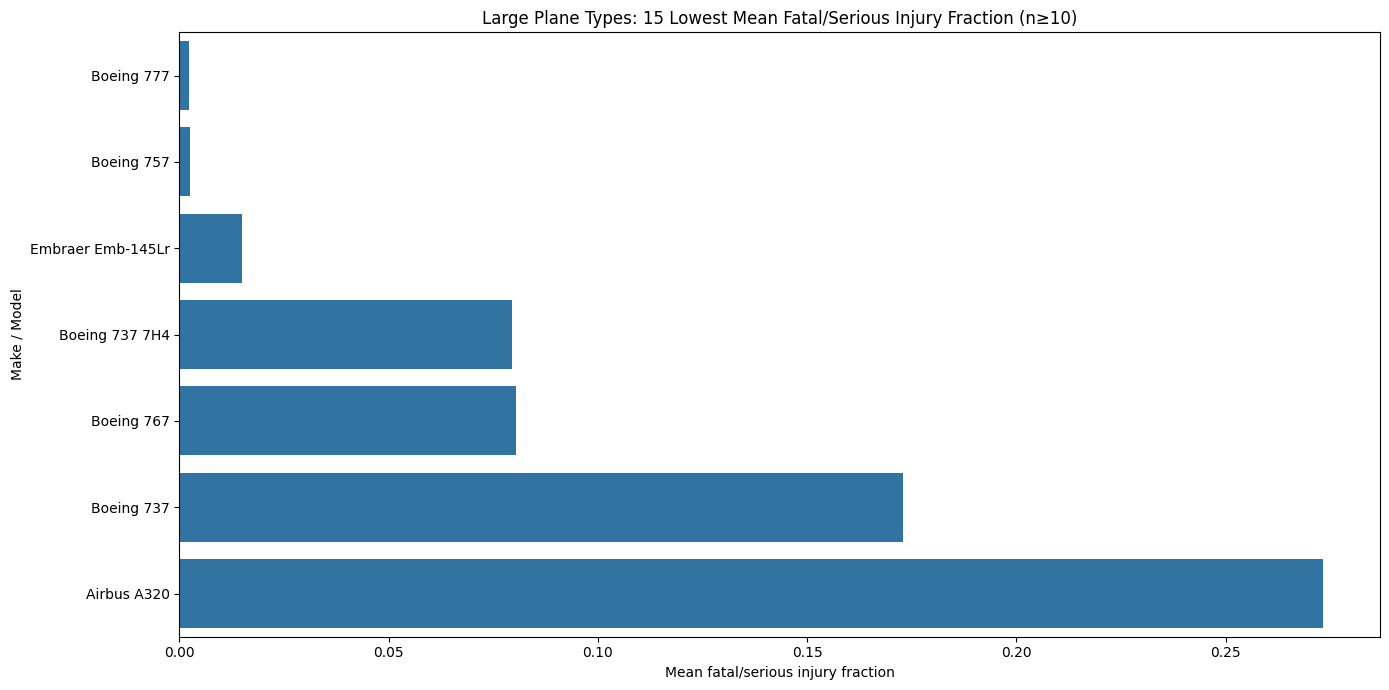

In [8]:
# Require at least 10 examples per plane type for robustness
MIN_SAMPLES_MODEL = 10

model_summary = (
    df.groupby(["plane_size", "Make_Model"])
      .agg(
          n_accidents=("Make_Model", "size"),
          mean_fatal_serious_frac=("fatal_serious_frac", "mean"),
          destroyed_rate=("is_destroyed", "mean"),
          make=("Make", lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
      )
      .reset_index()
)

model_summary_robust = model_summary[model_summary["n_accidents"] >= MIN_SAMPLES_MODEL].copy()

# Larger planes: show the 15 lowest mean fatal/serious fractions
large_models = (model_summary_robust[model_summary_robust["plane_size"] == "Large"]
                .nsmallest(15, "mean_fatal_serious_frac"))

plt.figure(figsize=(14, 7))
sns.barplot(data=large_models, x="mean_fatal_serious_frac", y="Make_Model")
plt.title("Large Plane Types: 15 Lowest Mean Fatal/Serious Injury Fraction (n≥10)")
plt.xlabel("Mean fatal/serious injury fraction")
plt.ylabel("Make / Model")
plt.tight_layout()

display(large_models[["Make_Model","n_accidents","mean_fatal_serious_frac","destroyed_rate","make"]].reset_index(drop=True))


**Smaller planes**
- for smaller planes, limit your plotted results to the makes with the 10 lowest mean serious/fatal injury fractions

,Make_Model,n_accidents,mean_fatal_serious_frac,destroyed_rate,make
0,Maule M-5-210C,11,0.000000,0.000000,Maule
1,Boeing 737,15,0.066667,0.066667,Boeing
2,Stinson 108-1,16,0.083333,0.000000,Stinson
3,Aeronca 15Ac,11,0.090909,0.000000,Aeronca
4,Bellanca 7Eca,25,0.120000,0.000000,Bellanca
5,Maule Mx7,18,0.125000,0.000000,Maule
6,Boeing A75N1(Pt17),31,0.139785,0.032258,Boeing
7,Aviat A-1B,21,0.142857,0.047619,Aviat
8,Bellanca 8Gcbc,23,0.152174,0.086957,Bellanca
9,Aeronca 7Ccm,10,0.166667,0.000000,Aeronca


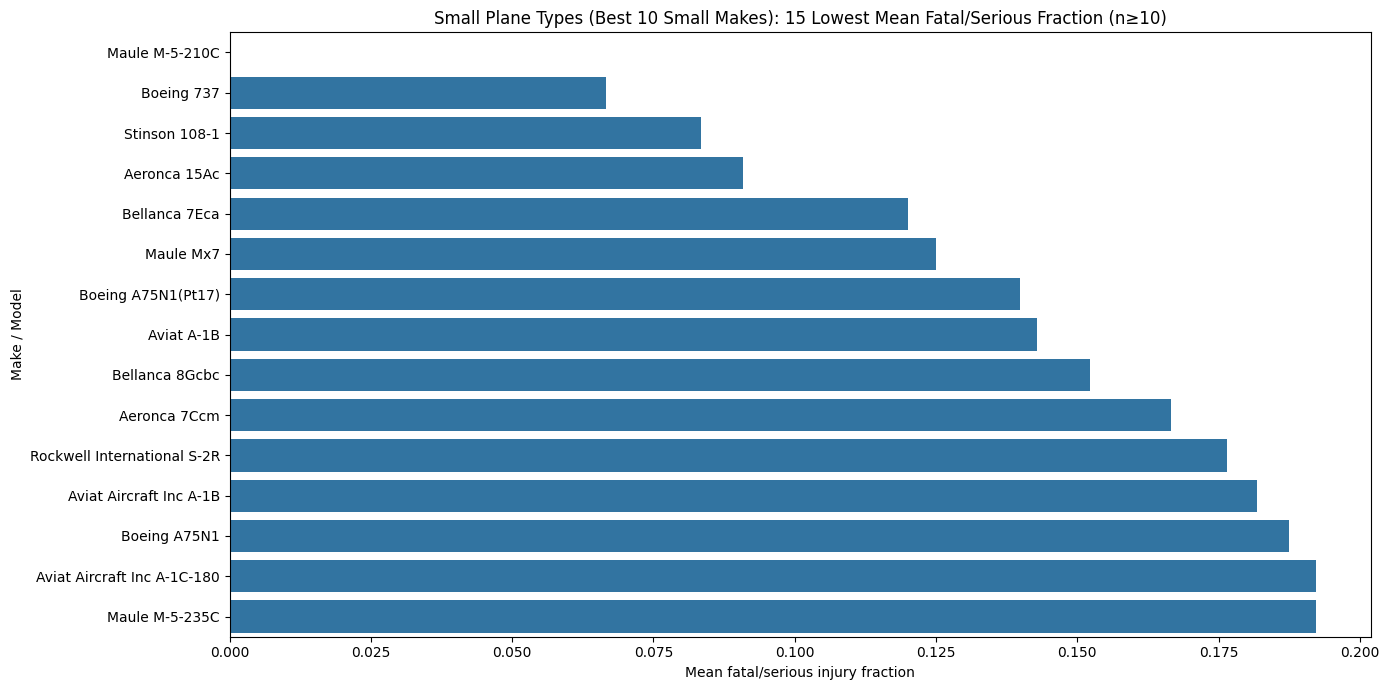

In [9]:
# Smaller planes: limit to makes with the 10 lowest mean serious/fatal injury fractions
best10_small_makes = top10_small["Make"].tolist()

small_models = model_summary_robust[
    model_summary_robust["plane_size"].str.startswith("Small") &
    model_summary_robust["make"].isin(best10_small_makes)
].copy()

# Within those makes, show the 15 lowest mean fatal/serious fractions by plane type
small_models_best = small_models.nsmallest(15, "mean_fatal_serious_frac")

plt.figure(figsize=(14, 7))
sns.barplot(data=small_models_best, x="mean_fatal_serious_frac", y="Make_Model")
plt.title("Small Plane Types (Best 10 Small Makes): 15 Lowest Mean Fatal/Serious Fraction (n≥10)")
plt.xlabel("Mean fatal/serious injury fraction")
plt.ylabel("Make / Model")
plt.tight_layout()

display(small_models_best[["Make_Model","n_accidents","mean_fatal_serious_frac","destroyed_rate","make"]].reset_index(drop=True))


### Discussion of Specific Airplane Types
- Discuss what you have found above regarding passenger fraction seriously/ both small and large airplane models.

### Discussion of Specific Airplane Types

To refine recommendations further, safety was analyzed at the Make–Model level, restricting to aircraft models with at least 10 recorded accidents to ensure minimum statistical reliability.

---

#### Large Aircraft Models

Large commercial aircraft models demonstrate extremely low fatal/serious injury fractions compared to small aircraft.

For example:

- **Boeing 777** (n=12) → Injury fraction ≈ 0.2%, destruction rate ≈ 8%
- **Boeing 757** (n=10) → Injury fraction ≈ 0.3%, destruction rate = 0%
- **Embraer EMB-145LR** (n=10) → Injury fraction ≈ 1.5%, destruction rate = 0%

These values are substantially lower than most small-aircraft models. Even within Boeing’s lineup, newer commercial jet models (e.g., 777, 757, 767) show much lower severity compared to older or mixed-use models (e.g., generic “Boeing 737” grouping).

This suggests that modern commercial passenger aircraft are associated with lower passenger injury severity and lower destruction probability given an accident.

However, sample sizes for some models (n≈10–12) are relatively small, so conclusions should be interpreted cautiously.

---

#### Small Aircraft Models

Among small aircraft, the top-performing models include:

- **Maule M-5-210C** (n=11) → 0% injury fraction, 0% destruction
- **Stinson 108-1** (n=16) → 8% injury fraction, 0% destruction
- **Aeronca 15AC** (n=11) → 9% injury fraction, 0% destruction

While these models show relatively strong outcomes within the small-aircraft category, even the best-performing small aircraft generally exhibit higher injury fractions (often 6–19%) compared to large commercial jets.

Additionally, small aircraft display greater dispersion in severity outcomes, suggesting higher variability in accident impact.

---

### Overall Pattern

The model-level analysis reinforces a consistent pattern:

- Large commercial aircraft models show significantly lower fatal/serious injury fractions.
- Small aircraft models, even strong performers, tend to have higher injury severity and greater variability.
- Some models show excellent results but are based on limited accident counts, requiring cautious interpretation.

From an insurer’s perspective, large commercial jet models appear to present lower severity risk per accident, while careful model selection is particularly important within small-aircraft categories.

### Exploring Other Variables
- Investigate how other variables effect aircraft damage and injury. You must choose **two** factors out of the following but are free to analyze more:

- Weather Condition
- Engine Type
- Number of Engines
- Phase of Flight
- Purpose of Flight

For each factor provide a discussion explaining your analysis with appropriate visualization / data summaries and interpreting your findings.

,Weather.Condition,n,mean_fatal_serious_frac,destroyed_rate
1,VMC,13952,0.237495,0.072391
0,IMC,866,0.647461,0.363741


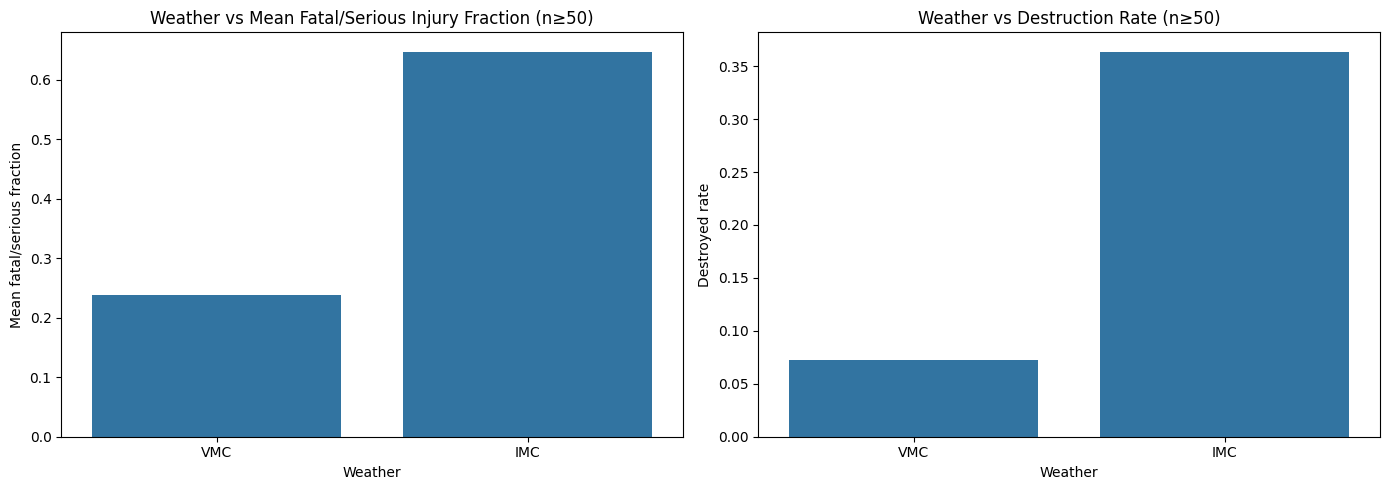

In [10]:
# 1) Weather vs outcomes
weather_summary = (
    df.groupby("Weather.Condition")
      .agg(
          n=("Weather.Condition","size"),
          mean_fatal_serious_frac=("fatal_serious_frac","mean"),
          destroyed_rate=("is_destroyed","mean")
      )
      .reset_index()
      .sort_values("n", ascending=False)
)

# Keep categories with enough data
MIN_SAMPLES_FACTOR = 50
weather_summary_robust = weather_summary[weather_summary["n"] >= MIN_SAMPLES_FACTOR].copy()

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.barplot(data=weather_summary_robust, x="Weather.Condition", y="mean_fatal_serious_frac", ax=axes[0])
axes[0].set_title("Weather vs Mean Fatal/Serious Injury Fraction (n≥50)")
axes[0].set_xlabel("Weather")
axes[0].set_ylabel("Mean fatal/serious fraction")

sns.barplot(data=weather_summary_robust, x="Weather.Condition", y="destroyed_rate", ax=axes[1])
axes[1].set_title("Weather vs Destruction Rate (n≥50)")
axes[1].set_xlabel("Weather")
axes[1].set_ylabel("Destroyed rate")

plt.tight_layout()
display(weather_summary_robust)



,Number.of.Engines,n,mean_fatal_serious_frac,destroyed_rate
0,1.0,13097,0.257394,0.077804
1,2.0,1918,0.324668,0.173097


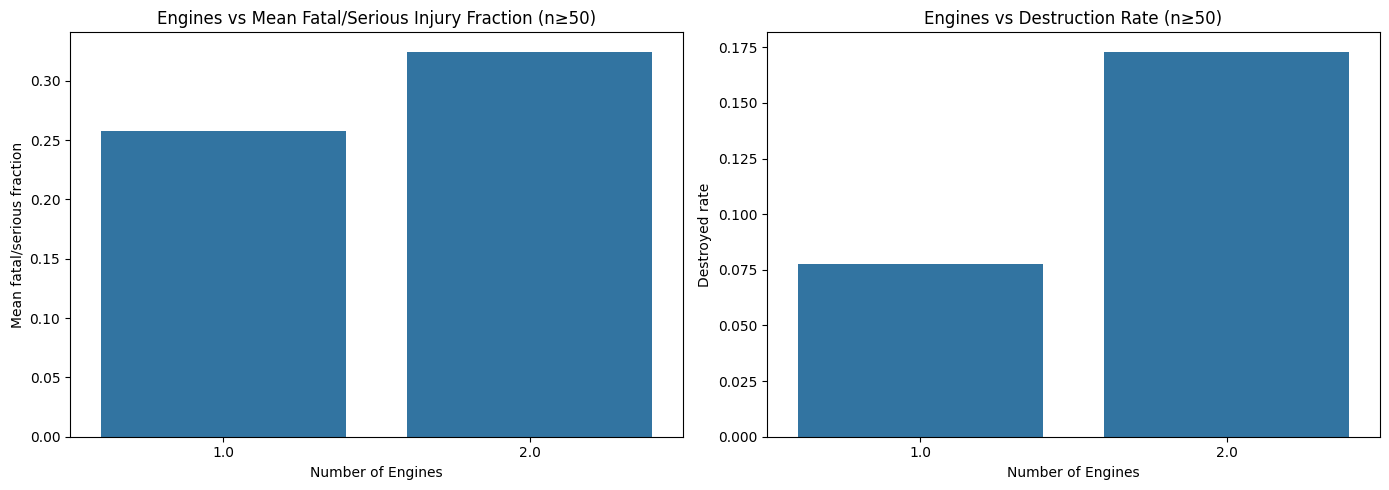

In [11]:
# 2) Number of engines vs outcomes
eng_summary = (
    df.dropna(subset=["Number.of.Engines"])
      .groupby("Number.of.Engines")
      .agg(
          n=("Number.of.Engines","size"),
          mean_fatal_serious_frac=("fatal_serious_frac","mean"),
          destroyed_rate=("is_destroyed","mean")
      )
      .reset_index()
      .sort_values("Number.of.Engines")
)

eng_summary_robust = eng_summary[eng_summary["n"] >= MIN_SAMPLES_FACTOR].copy()

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.barplot(data=eng_summary_robust, x="Number.of.Engines", y="mean_fatal_serious_frac", ax=axes[0])
axes[0].set_title("Engines vs Mean Fatal/Serious Injury Fraction (n≥50)")
axes[0].set_xlabel("Number of Engines")
axes[0].set_ylabel("Mean fatal/serious fraction")

sns.barplot(data=eng_summary_robust, x="Number.of.Engines", y="destroyed_rate", ax=axes[1])
axes[1].set_title("Engines vs Destruction Rate (n≥50)")
axes[1].set_xlabel("Number of Engines")
axes[1].set_ylabel("Destroyed rate")

plt.tight_layout()
display(eng_summary_robust)


## Factors Potentially Affecting Injury and Damage Outcomes

Beyond aircraft make and model, two additional variables show strong associations with accident severity: **Weather Condition** and **Number of Engines**.

---

### 1) Weather Condition

Comparing Visual Meteorological Conditions (VMC) and Instrument Meteorological Conditions (IMC):

- **VMC (n = 13,952)**  
  - Mean fatal/serious injury fraction ≈ 23.7%  
  - Destruction rate ≈ 7.2%

- **IMC (n = 866)**  
  - Mean fatal/serious injury fraction ≈ 64.7%  
  - Destruction rate ≈ 36.4%

Accidents occurring in IMC are associated with dramatically higher injury severity and aircraft destruction rates compared to VMC conditions.

The magnitude of this difference is substantial:
- Injury fraction is nearly **3 times higher** in IMC.
- Destruction rate is approximately **5 times higher** in IMC.

This suggests that reduced visibility and adverse weather conditions are strongly correlated with more severe accident outcomes.

---

### 2) Number of Engines

Comparing single-engine and twin-engine aircraft:

- **1 Engine (n = 13,097)**  
  - Mean fatal/serious injury fraction ≈ 25.7%  
  - Destruction rate ≈ 7.8%

- **2 Engines (n = 1,918)**  
  - Mean fatal/serious injury fraction ≈ 32.5%  
  - Destruction rate ≈ 17.3%

Twin-engine aircraft show higher average injury severity and more than double the destruction rate compared to single-engine aircraft in this accident dataset.

However, this relationship may be influenced by confounding factors. Multi-engine aircraft are often larger, operate under different flight conditions, and may be more likely to encounter complex operational environments. Therefore, engine count itself may not be the direct cause, but it is clearly associated with higher observed severity outcomes.

---

### Overall Interpretation

Both weather condition and aircraft configuration are strongly associated with accident severity:

- **IMC conditions** are linked to substantially worse injury and destruction outcomes.
- **Twin-engine aircraft** show higher severity metrics within recorded accidents.

For insurers, this suggests that environmental and operational context can meaningfully influence loss severity, in addition to aircraft make and model.